In [1]:
!pip install striprtf

In [4]:
import os
import re
import pandas as pd

# === Настройка соответствия имён файлов и имён методов ===
method_map = {
    "HumanEval on Qwen:Qwen2.5-Coder-3B.rtf": "BASE",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + CHAIN.rtf": "BASE_CHAIN",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + AST.rtf": "AST",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + AST + CHAIN.rtf": "AST_CHAIN",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + DFG.rtf": "DFG",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + DFG + CHAIN.rtf": "DFG_CHAIN",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + CFG.rtf": "CFG",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + CFG + CHAIN.rtf": "CFG_CHAIN",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + PDG.rtf": "PDG",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN.rtf": "PDG_CHAIN",
    "HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN + Feedback.rtf": "PDG_CHAIN_FEEDBACK",
}

# === Функция очистки RTF ===
def extract_text_from_rtf(rtf: str) -> str:
    # 1. преобразуем \uXXXX?
    rtf = re.sub(r'\\u(-?\d+)\??', lambda m: chr(int(m.group(1)) % 65536), rtf)

    # 2. убираем { ... }
    rtf = re.sub(r'{\\.*?}', '', rtf)

    # 3. убираем управляющие команды \word или \word123
    rtf = re.sub(r'\\[a-zA-Z]+\d* ?', '', rtf)

    # 4. убираем лишние { }
    rtf = rtf.replace("{", "").replace("}", "")

    return rtf


# === Шаблоны ===
pattern_pass = re.compile(r"HumanEval tests for (.+?) passed successfully")
pattern_fail = re.compile(r"SYNTAX ERROR.*?for (.+)")

results = []

# === Читаем все файлы ===
for fname, method in method_map.items():
    if not os.path.exists(fname):
        print(f"[WARN] Файл не найден: {fname}")
        continue

    with open(fname, "r", encoding="utf-8", errors="ignore") as f:
        raw = f.read()

    # Чистый текст RTF
    text = extract_text_from_rtf(raw)

    # Разбиваем на строки
    for line in text.splitlines():
        line = line.strip()

        m_pass = pattern_pass.search(line)
        m_fail = pattern_fail.search(line)

        if m_pass:
            test_name = m_pass.group(1).strip()
            results.append([test_name, method, 1])
        elif m_fail:
            test_name = m_fail.group(1).strip()
            results.append([test_name, method, 0])


# === Формируем DataFrame ===
df = pd.DataFrame(results, columns=["test_name", "method", "passed"])

# Добавляем ID теста
unique_tests = sorted(df["test_name"].unique())
test_id_map = {name: i + 1 for i, name in enumerate(unique_tests)}
df["test_id"] = df["test_name"].map(test_id_map)

# === Сохраняем CSV ===
df.to_csv("humaneval_results.csv", index=False, encoding="utf-8-sig")

print("\n=== Готово! CSV сохранён как humaneval_results.csv ===\n")

# === Печатаем статистику ===
total_tests = len(unique_tests)

for method in df["method"].unique():
    passed = df[(df["method"] == method) & (df["passed"] == 1)].shape[0]
    percent = passed / total_tests * 100
    print(f"{method:25s}: {passed}/{total_tests} ({percent:.1f}%)")


[WARN] Файл не найден: HumanEval on Qwen:Qwen2.5-Coder-3B + CHAIN.rtf
[WARN] Файл не найден: HumanEval on Qwen:Qwen2.5-Coder-3B + AST + CHAIN.rtf
[WARN] Файл не найден: HumanEval on Qwen:Qwen2.5-Coder-3B + DFG + CHAIN.rtf
[WARN] Файл не найден: HumanEval on Qwen:Qwen2.5-Coder-3B + CFG + CHAIN.rtf
[WARN] Файл не найден: HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN + Feedback.rtf

=== Готово! CSV сохранён как humaneval_results.csv ===

BASE                     : 103/268 (38.4%)
AST                      : 152/268 (56.7%)
DFG                      : 119/268 (44.4%)
CFG                      : 123/268 (45.9%)
PDG                      : 140/268 (52.2%)
PDG_CHAIN                : 153/268 (57.1%)


In [14]:
import re
import pandas as pd
from striprtf.striprtf import rtf_to_text

# --- Файлы методов ---
method_files = {
    "BASE": "HumanEval on Qwen:Qwen2.5-Coder-3B.rtf",
    "BASE_CHAIN": "HumanEval on Qwen:Qwen2.5-Coder-3B\xa0 + CHAIN.rtf",
    "AST": "HumanEval on Qwen:Qwen2.5-Coder-3B + AST.rtf",
    "AST_CHAIN": "HumanEval on Qwen:Qwen2.5-Coder-3B + AST + CHAIN\xa0.rtf",
    "DFG": "HumanEval on Qwen:Qwen2.5-Coder-3B + DFG.rtf",
    "DFG_CHAIN": "HumanEval on Qwen:Qwen2.5-Coder-3B + DFG + CHAIN\xa0.rtf",
    "CFG": "HumanEval on Qwen:Qwen2.5-Coder-3B + CFG.rtf",
    "CFG_CHAIN": "HumanEval on Qwen:Qwen2.5-Coder-3B + СFG + CHAIN\xa0.rtf",
    "PDG": "HumanEval on Qwen:Qwen2.5-Coder-3B + PDG.rtf",
    "PDG_CHAIN": "HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN.rtf",
    "PDG_CHAIN_FEEDBACK": "HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN\xa0+ Feedback.rtf",
}

# --- Регулярные выражения ---
pattern_pass = re.compile(r"HumanEval tests for (.+?) passed successfully")
pattern_fail = re.compile(r"(?:SYNTAX ERROR|RUNTIME ERROR).+? for (.+)")

# --- Строгий порядок тестов ---
all_tests_ordered = [
    "has_close_elements",
    "separate_paren_groups",
    "truncate_number",
    "below_zero",
    "mean_absolute_deviation",
    "intersperse",
    "parse_nested_parens",
    "filter_by_substring",
    "sum_product",
    "rolling_max",
    "make_palindrome",
    "string_xor",
    "longest",
    "greatest_common_divisor",
    "all_prefixes",
    "string_sequence",
    "count_distinct_characters",
    "parse_music",
    "how_many_times",
    "sort_numbers",
    "find_closest_elements",
    "rescale_to_unit",
    "filter_integers",
    "strlen",
    "largest_divisor",
    "factorize",
    "remove_duplicates",
    "flip_case",
    "concatenate",
    "filter_by_prefix",
    "get_positive",
    "is_prime",
    "find_zero",
    "sort_third",
    "unique",
    "max_element",
    "fizz_buzz",
    "sort_even",
    "decode_cyclic",
    "prime_fib",
    "triples_sum_to_zero",
    "car_race_collision",
    "incr_list",
    "pairs_sum_to_zero",
    "change_base",
    "triangle_area",
    "fib4",
    "median",
    "is_palindrome",
    "modp",
    "decode_shift",
    "remove_vowels",
    "below_threshold",
    "add",
    "same_chars",
    "fib",
    "correct_bracketing",
    "monotonic",
    "common",
    "largest_prime_factor",
    "sum_to_n",
    "correct_bracketing",
    "derivative",
    "fibfib",
    "vowels_count",
    "circular_shift",
    "digitSum",
    "fruit_distribution",
    "pluck",
    "search",
    "strange_sort_list",
    "triangle_area",
    "will_it_fly",
    "smallest_change",
    "total_match",
    "is_multiply_prime",
    "is_simple_power",
    "iscube",
    "hex_key",
    "decimal_to_binary",
    "is_happy",
    "numerical_letter_grade",
    "prime_length",
    "starts_one_ends",
    "solve",
    "add",
    "anti_shuffle",
    "get_row",
    "sort_array",
    "encrypt",
    "next_smallest",
    "is_bored",
    "any_int",
    "encode",
    "skjkasdkd",
    "check_dict_case",
    "count_up_to",
    "multiply",
    "count_upper",
    "closest_integer",
    "make_a_pile",
    "words_string",
    "choose_num",
    "rounded_avg",
    "unique_digits",
    "by_length",
    "f",
    "even_odd_palindrome",
    "count_nums",
    "move_one_ball",
    "exchange",
    "histogram",
    "reverse_delete",
    "odd_count",
    "minSubArraySum",
    "max_fill",
    "sort_array",
    "select_words",
    "get_closest_vowel",
    "match_parens",
    "maximum",
    "solution",
    "add_elements",
    "get_odd_collatz",
    "valid_date",
    "split_words",
    "is_sorted",
    "intersection",
    "prod_signs",
    "minPath",
    "tri",
    "digits",
    "is_nested",
    "sum_squares",
    "check_if_last_char_is_a_letter",
    "can_arrange",
    "largest_smallest_integers",
    "compare_one",
    "is_equal_to_sum_even",
    "special_factorial",
    "fix_spaces",
    "file_name_check",
    "sum_squares",
    "words_in_sentence",
    "simplify",
    "order_by_points",
    "specialFilter",
    "get_max_triples",
    "bf",
    "sorted_list_sum",
    "x_or_y",
    "double_the_difference",
    "compare",
    "Strongest_Extension",
    "cycpattern_check",
    "even_odd_count",
    "int_to_mini_roman",
    "right_angle_triangle",
    "find_max",
    "eat",
    "do_algebra",
    "solve",
    "string_to_md5",
    "generate_integers",
]

# --- Чтение файлов и сбор данных ---
data = {}

for method, filename in method_files.items():
    print(f"Читаем {filename} ...")
    try:
        with open(filename, "r", encoding="utf-8", errors="ignore") as f:
            text = rtf_to_text(f.read())
    except Exception as e:
        print(f"[ERROR] Проблема с файлом {filename}: {e}")
        continue

    data[method] = {}
    for line in text.splitlines():
        line = line.strip()
        m1 = pattern_pass.search(line)
        m2 = pattern_fail.search(line)
        if m1:
            name = m1.group(1).strip()
            data[method][name] = 1
        elif m2:
            name = m2.group(1).strip()
            data[method][name] = 0

# --- Создание DataFrame ---
df = pd.DataFrame({"test_name": all_tests_ordered})
df["test_id"] = range(1, len(all_tests_ordered) + 1)

for method in method_files.keys():
    df[method] = df["test_name"].apply(lambda t: data.get(method, {}).get(t, 0))

# --- Сохранение CSV ---
df.to_csv("humaneval_matrix.csv", index=False, encoding="utf-8-sig")

# --- Статистика ---
print("\n=== Статистика ===")
total = len(all_tests_ordered)
for method in method_files.keys():
    passed = df[method].sum()
    print(f"{method:20s}: {passed}/{total} ({passed/total*100:.1f}%)")


Читаем HumanEval on Qwen:Qwen2.5-Coder-3B.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B  + CHAIN.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + AST.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + AST + CHAIN .rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + DFG.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + DFG + CHAIN .rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + CFG.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + СFG + CHAIN .rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + PDG.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN.rtf ...
Читаем HumanEval on Qwen:Qwen2.5-Coder-3B + PDG + CHAIN + Feedback.rtf ...

=== Статистика ===
BASE                : 104/164 (63.4%)
BASE_CHAIN          : 132/164 (80.5%)
AST                 : 152/164 (92.7%)
AST_CHAIN           : 113/164 (68.9%)
DFG                 : 119/164 (72.6%)
DFG_CHAIN           : 129/164 (78.7%)
CFG                 : 124/164 (75.6%)
CFG_CHAIN           : 146/164 (89.0%)
PDG      

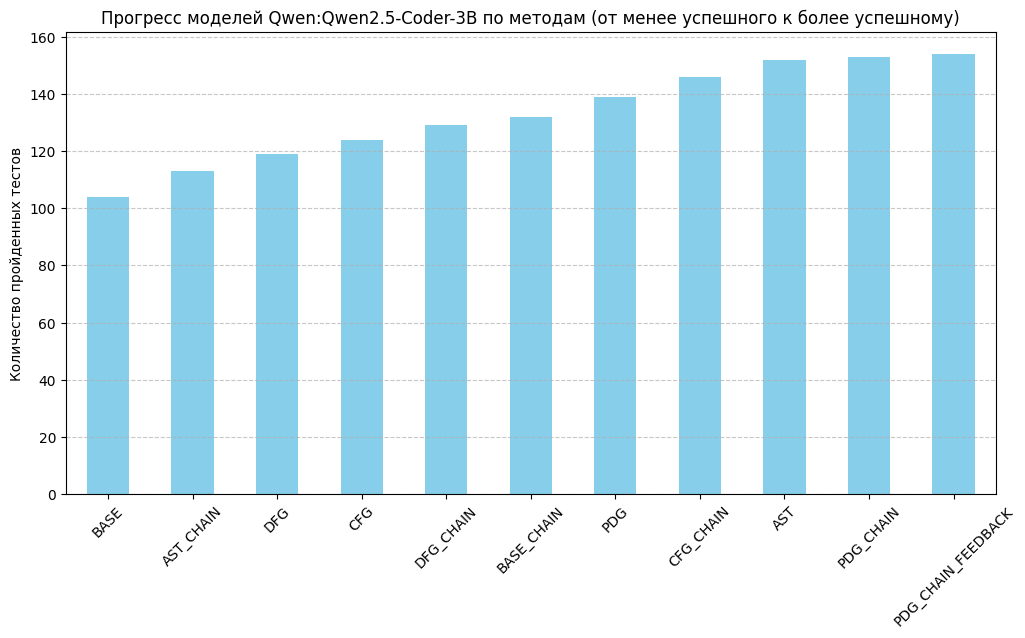

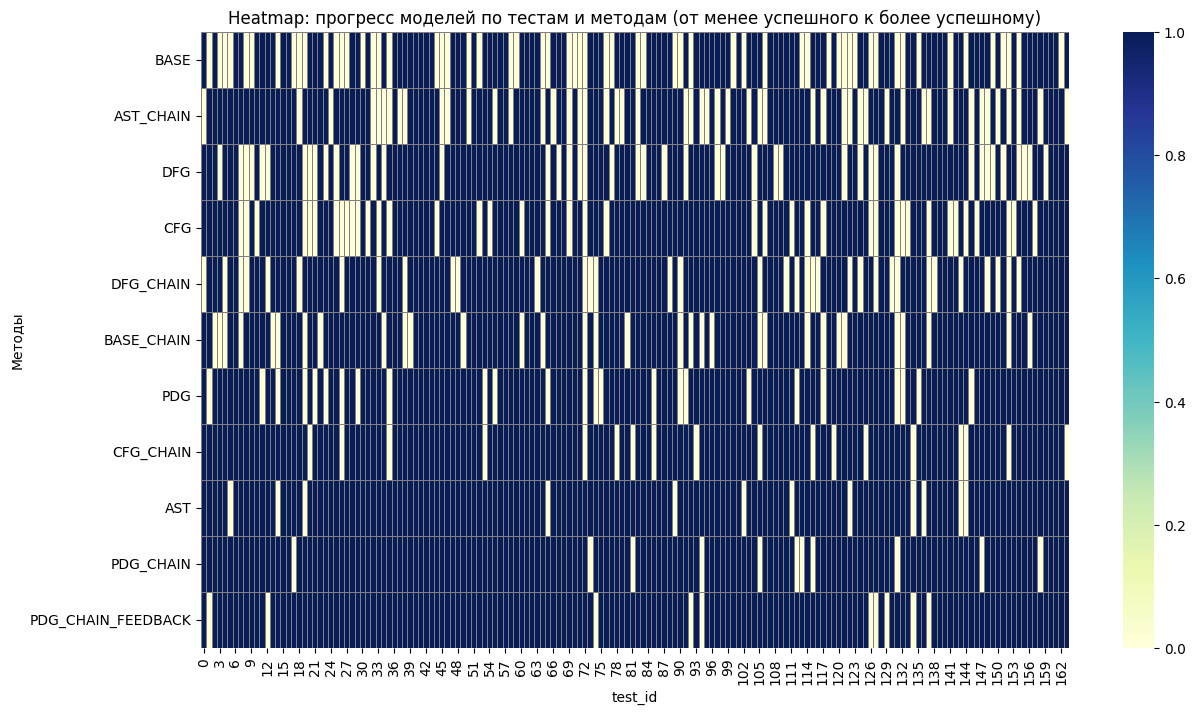

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем CSV
df = pd.read_csv("humaneval_matrix.csv")

# Список всех методов
methods = [
    "BASE", "BASE_CHAIN", "AST", "AST_CHAIN",
    "DFG", "DFG_CHAIN", "CFG", "CFG_CHAIN",
    "PDG", "PDG_CHAIN", "PDG_CHAIN_FEEDBACK"
]

# Сортировка методов по количеству пройденных тестов
methods_sorted = df[methods].sum().sort_values().index.tolist()

# Bar chart: количество пройденных тестов на каждом методе
passed_counts = df[methods_sorted].sum()
plt.figure(figsize=(12,6))
passed_counts.plot(kind='bar', color='skyblue')
plt.ylabel("Количество пройденных тестов")
plt.title("Прогресс моделей Qwen:Qwen2.5-Coder-3B по методам (от менее успешного к более успешному)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Heatmap: обзор всех тестов и методов
plt.figure(figsize=(14,8))
heatmap_data = df[methods_sorted]
sns.heatmap(heatmap_data.T, cmap="YlGnBu", cbar=True, linewidths=0.5, linecolor='gray')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Heatmap: прогресс моделей по тестам и методам (от менее успешного к более успешному)")
plt.xlabel("test_id")
plt.ylabel("Методы")
plt.show()


<Figure size 1400x700 with 0 Axes>

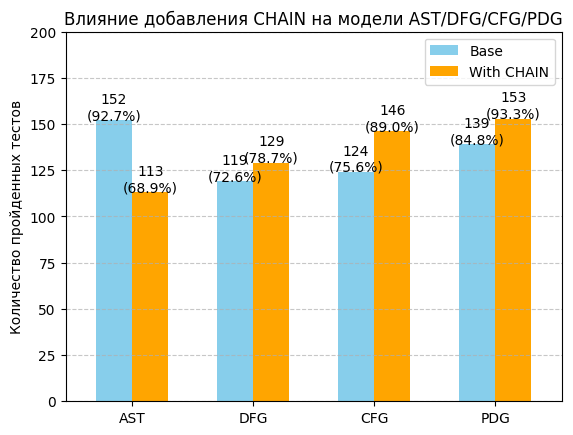

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем CSV
df = pd.read_csv("humaneval_matrix.csv")

# Определяем группы методов
base_methods = ["AST", "DFG", "CFG", "PDG"]
chain_methods = ["AST_CHAIN", "DFG_CHAIN", "CFG_CHAIN", "PDG_CHAIN"]

# Считаем количество пройденных тестов для каждой группы
base_passed = df[base_methods].sum()
chain_passed = df[chain_methods].sum().values  # соответствие по индексам

# Объединяем в DataFrame для удобной визуализации
comparison_df = pd.DataFrame({
    "Base": base_passed,
    "With CHAIN": chain_passed
}, index=base_methods)

# Bar chart: сравнение Base vs Base + CHAIN
plt.figure(figsize=(14,7))
bars = comparison_df.plot(kind='bar', color=["skyblue", "orange"], width=0.6)
plt.ylabel("Количество пройденных тестов")
plt.title("Влияние добавления CHAIN на модели AST/DFG/CFG/PDG")
plt.xticks(rotation=0)
plt.ylim(0, 200)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем текст с процентами над каждым столбцом
total_tests = len(df)
for i, method in enumerate(base_methods):
    base_val = comparison_df.loc[method, "Base"]
    chain_val = comparison_df.loc[method, "With CHAIN"]
    base_pct = base_val / total_tests * 100
    chain_pct = chain_val / total_tests * 100
    plt.text(i - 0.15, base_val + 0.5, f"{base_val}\n({base_pct:.1f}%)", ha='center', fontsize=10)
    plt.text(i + 0.15, chain_val + 0.5, f"{chain_val}\n({chain_pct:.1f}%)", ha='center', fontsize=10)

plt.show()
